<a href="https://colab.research.google.com/github/YoussefDiaa1/Colorization-Auto-Encoder-project/blob/main/Colorization_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
import os

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define Project Path
# This will create a folder named 'ColorizationProject' in your main Drive
PROJECT_PATH = '/content/drive/MyDrive/ColorizationProject'

# 3. Create Directories (data, models, results) if they don't exist automatically
if not os.path.exists(PROJECT_PATH):
    os.makedirs(f"{PROJECT_PATH}/Data")
    os.makedirs(f"{PROJECT_PATH}/Models")
    os.makedirs(f"{PROJECT_PATH}/Results")
    print(f"Created project folder at: {PROJECT_PATH}")
else:
    print(f"Project folder found at: {PROJECT_PATH}")

# 4. Set Working Directory
os.chdir(PROJECT_PATH)
print(f"Current working directory: {os.getcwd()}")

Mounted at /content/drive
Project folder found at: /content/drive/MyDrive/ColorizationProject
Current working directory: /content/drive/MyDrive/ColorizationProject


In [2]:
from torchvision import datasets

print("Checking/Downloading STL-10 Dataset...")

# We use split='unlabeled' to get the massive 100k dataset
# This will save inside your Drive under /ColorizationProject/data
raw_dataset = datasets.STL10(root='./Data', split='unlabeled', download=True)

print("Done!")
print(f"Total Images Loaded: {len(raw_dataset)}")

Checking/Downloading STL-10 Dataset...


100%|██████████| 2.64G/2.64G [01:56<00:00, 22.6MB/s]


Done!
Total Images Loaded: 100000


Chart saved to: /content/drive/MyDrive/ColorizationProject/Results/01_eda_samples.png


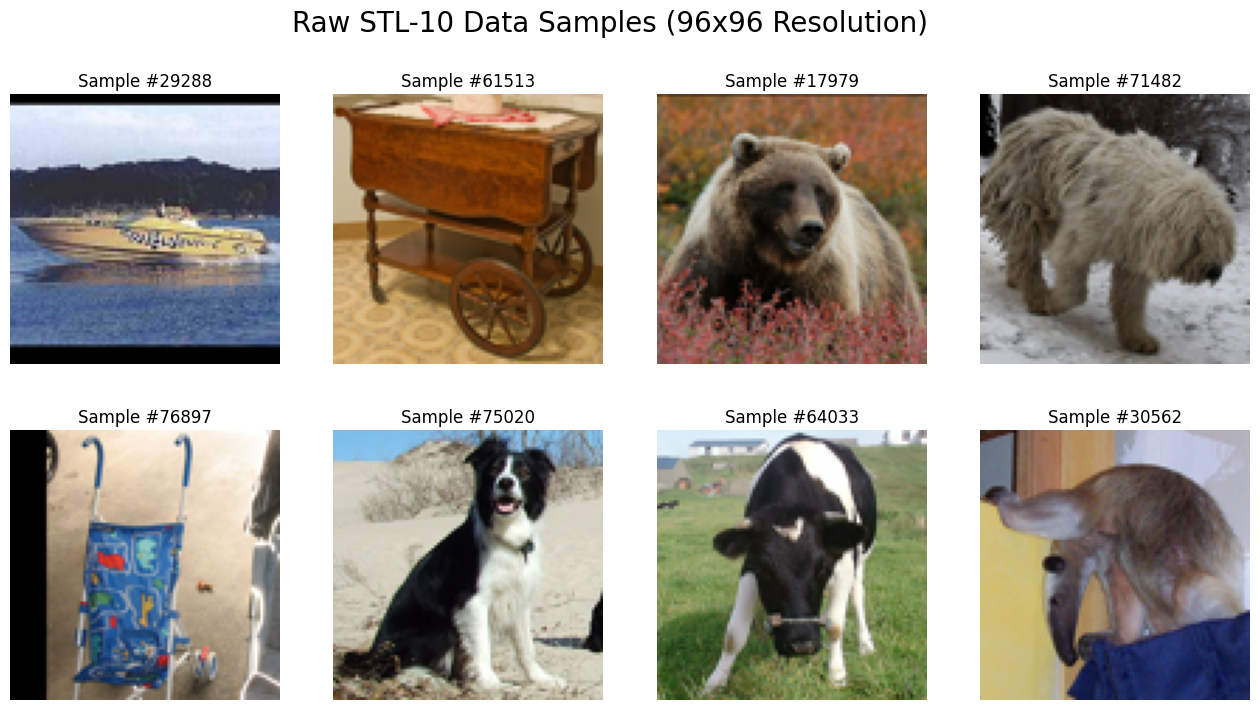

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Visualization Function
def visualize_random_samples(dataset):
    # Create a figure with 2 rows and 4 columns
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    plt.suptitle(f"Raw STL-10 Data Samples (96x96 Resolution)", fontsize=20)

    for i in range(8):
        # Pick a random number between 0 and 100,000
        idx = np.random.randint(0, len(dataset))

        # Get the image
        img, _ = dataset[idx]
        img = np.array(img) # Convert from Tensor to Numpy for plotting

        # Calculate where to put it in the grid
        row = i // 4
        col = i % 4

        # Show it
        axes[row, col].imshow(img)
        axes[row, col].axis('off') # Hide the ugly X/Y axis numbers
        axes[row, col].set_title(f"Sample #{idx}")

    # Save the plot to your Drive (Results folder)
    save_path = f"{PROJECT_PATH}/Results/01_eda_samples.png"
    plt.savefig(save_path)
    print(f"Chart saved to: {save_path}")
    plt.show()

# 2. Run the function on the 'raw_dataset' we downloaded in the previous cell
visualize_random_samples(raw_dataset)

Testing Feature Engineering Pipeline...
Success! Saved check image to 'Results/02_engineering_check.png'


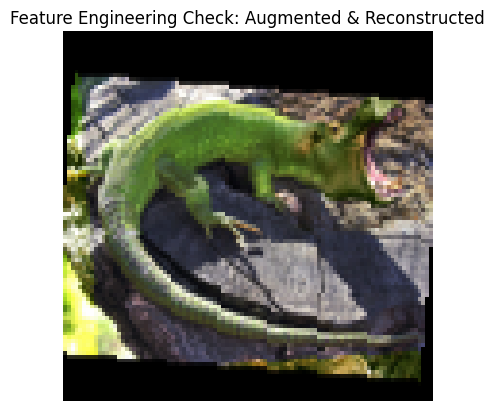

In [7]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from skimage.color import rgb2lab, lab2rgb
import numpy as np
import matplotlib.pyplot as plt
import os

# 1. Define the Feature Engineering Class
class STLColorization(datasets.STL10):
    def __init__(self, root, split='unlabeled', download=True):
        super().__init__(root, split=split, download=download)

        # FEATURE ENGINEERING: Augmentation (Flip & Rotate)
        self.augments = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
        ])

    def __getitem__(self, index):
        img, _ = super().__getitem__(index)

        # Apply Augmentation
        img = self.augments(img)
        img_np = np.array(img)

        # FEATURE ENGINEERING: RGB -> Lab Space
        img_lab = rgb2lab(img_np).astype("float32")
        img_lab = transforms.ToTensor()(img_lab)

        # Normalize/Scale
        L = img_lab[[0], ...] / 100.0
        ab = img_lab[[1, 2], ...] / 128.0

        return L, ab

# 2. Test the Pipeline
print("Testing Feature Engineering Pipeline...")
dataset = STLColorization(root='./Data', split='unlabeled', download=False)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

# Get one image batch
L, ab = next(iter(loader))

# 3. Visual Sanity Check (THE FIX IS HERE)
# We transpose L just like we did for ab
test_L = L[0].numpy().transpose(1, 2, 0) * 100      # Shape becomes (96, 96, 1)
test_ab = ab[0].numpy().transpose(1, 2, 0) * 128    # Shape becomes (96, 96, 2)

# Now they have matching height/width, so we can glue them
test_lab = np.concatenate([test_L, test_ab], axis=2) # Shape becomes (96, 96, 3)
test_rgb = lab2rgb(test_lab)

plt.imshow(test_rgb)
plt.title("Feature Engineering Check: Augmented & Reconstructed")
plt.axis('off')

# Save proof to Drive
PROJECT_PATH = '/content/drive/MyDrive/ColorizationProject'
plt.savefig(f"{PROJECT_PATH}/Results/02_engineering_check.png")
print("Success! Saved check image to 'Results/02_engineering_check.png'")
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training on: cuda
Starting Training...
Epoch [1/3] Step [200/1563] Loss: 0.0098
Epoch [1/3] Step [400/1563] Loss: 0.0103
Epoch [1/3] Step [600/1563] Loss: 0.0128
Epoch [1/3] Step [800/1563] Loss: 0.0079
Epoch [1/3] Step [1000/1563] Loss: 0.0092
Epoch [1/3] Step [1200/1563] Loss: 0.0072
Epoch [1/3] Step [1400/1563] Loss: 0.0091
--> EPOCH 1 FINISHED. Avg Loss: 0.01069
    Saved model to: /content/drive/MyDrive/ColorizationProject/Models/model_epoch_1.pth
Epoch [2/3] Step [200/1563] Loss: 0.0089
Epoch [2/3] Step [400/1563] Loss: 0.0109
Epoch [2/3] Step [600/1563] Loss: 0.0082
Epoch [2/3] Step [800/1563] Loss: 0.0089
Epoch [2/3] Step [1000/1563] Loss: 0.0074
Epoch [2/3] Step [1200/1563] Loss: 0.0087
Epoch [2/3] Step [1400/1563] Loss: 0.0086
--> EPOCH 2 FINISHED. Avg Loss: 0.00899
    Saved model to: /content/drive/MyDrive/ColorizationProject/Models/model_epoch_2.

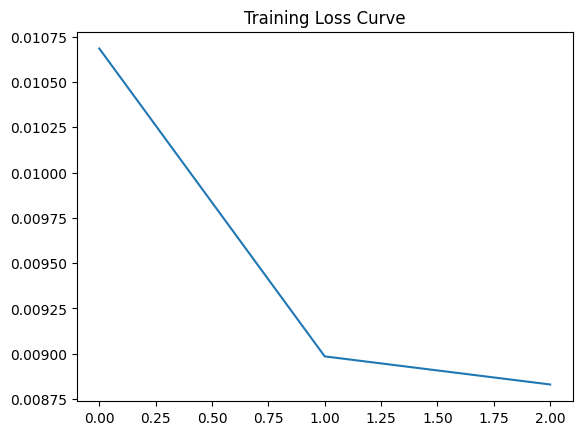

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms  # <--- This was missing!
from skimage.color import rgb2lab, lab2rgb
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive # <--- Need to re-mount drive after restart

# 1. RE-CONNECT DRIVE & SETUP PATHS
drive.mount('/content/drive')
PROJECT_PATH = '/content/drive/MyDrive/ColorizationProject'

# Ensure folders exist (just in case)
os.makedirs(f"{PROJECT_PATH}/Models", exist_ok=True)
os.makedirs(f"{PROJECT_PATH}/Results", exist_ok=True)

# 2. DEFINE DATASET CLASS (The Recipe)
class STLColorization(datasets.STL10):
    def __init__(self, root, split='unlabeled', download=False):
        # download=True ensures it finds the files even if connection reset
        super().__init__(root, split=split, download=True)
        self.augments = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
        ])
    def __getitem__(self, index):
        img, _ = super().__getitem__(index)
        img = self.augments(img)
        img_np = np.array(img)
        img_lab = rgb2lab(img_np).astype("float32")
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 100.0
        ab = img_lab[[1, 2], ...] / 128.0
        return L, ab

# 3. DEFINE MODEL ARCHITECTURE (The Brain)
class Colorizer96(nn.Module):
    def __init__(self):
        super(Colorizer96, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 512, 3, stride=2, padding=1), nn.BatchNorm2d(512), nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 2, 3, stride=2, padding=1, output_padding=1), nn.Tanh()
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

# 4. TRAINING SETUP
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {DEVICE}") # Should say 'cuda'

# Load Data (It will verify files exist in ./data)
train_data = STLColorization(root='./Data', split='unlabeled', download=True)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)

model = Colorizer96().to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 5. START TRAINING
EPOCHS = 3
loss_history = []

print("Starting Training...")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for i, (L, ab) in enumerate(train_loader):
        L, ab = L.to(DEVICE), ab.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(L)
        loss = criterion(outputs, ab)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i+1) % 200 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}] Step [{i+1}/{len(train_loader)}] Loss: {loss.item():.4f}")

    avg_loss = running_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"--> EPOCH {epoch+1} FINISHED. Avg Loss: {avg_loss:.5f}")

    # SAVE TO DRIVE
    save_loc = f"{PROJECT_PATH}/Models/model_epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), save_loc)
    print(f"    Saved model to: {save_loc}")

print("Training Complete!")
plt.plot(loss_history)
plt.title("Training Loss Curve")
plt.savefig(f"{PROJECT_PATH}/Results/03_loss_curve.png")
plt.show()

SUCCESS: Loaded weights from /content/drive/MyDrive/ColorizationProject/Models/model_epoch_3.pth
Saved result image to 'Results/04_final_demo.png'


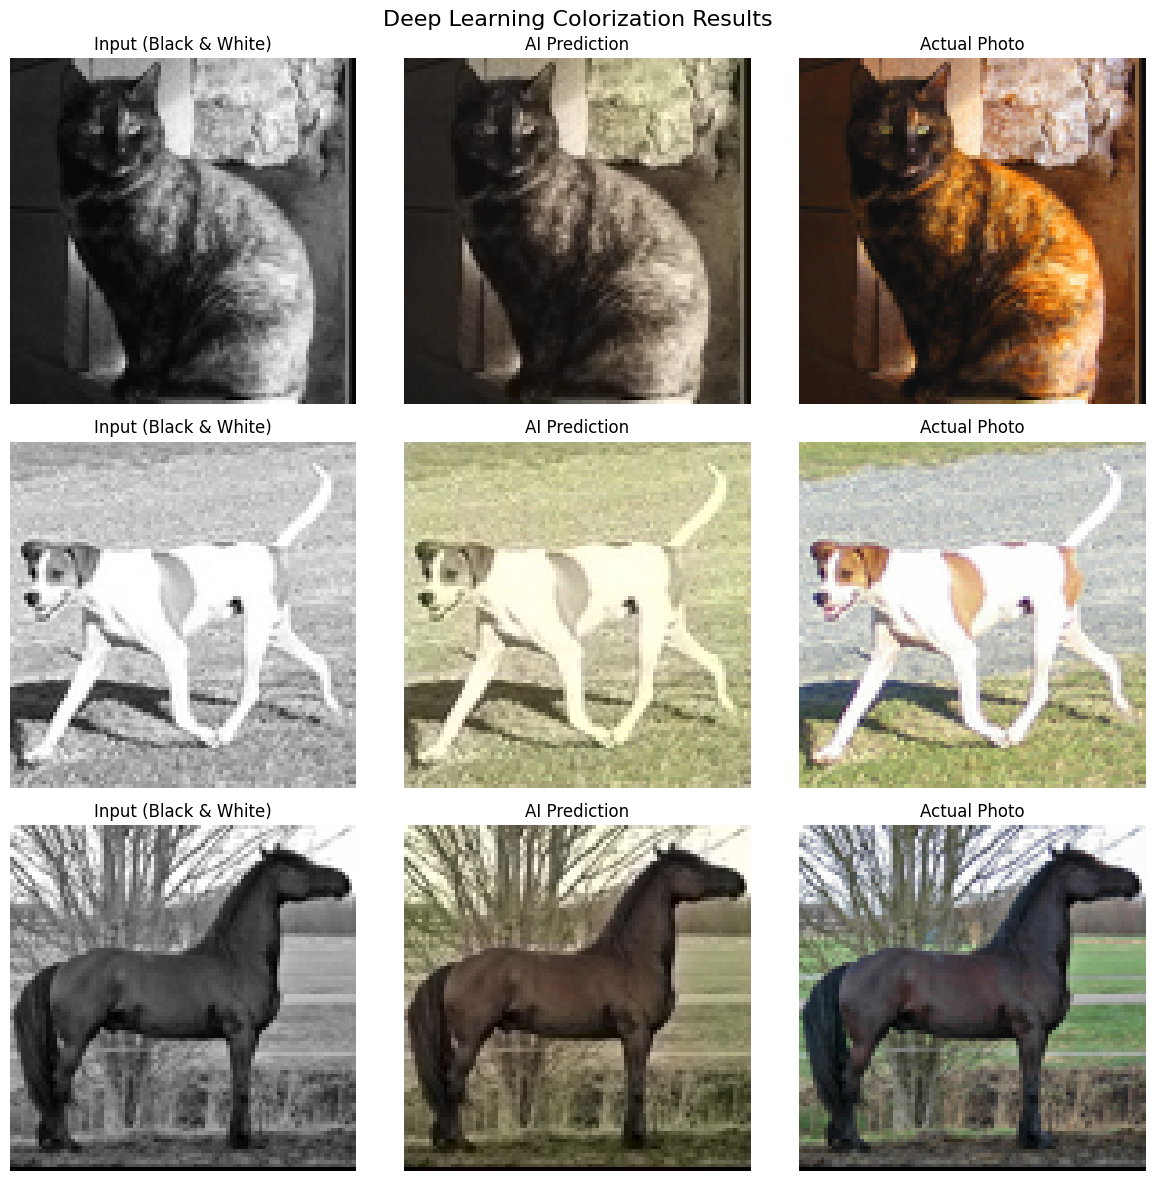

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from skimage.color import lab2rgb
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive

# 1. SETUP & MODEL DEFINITION (Must define the brain to load weights into it)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PROJECT_PATH = '/content/drive/MyDrive/ColorizationProject'

class Colorizer96(nn.Module):
    def __init__(self):
        super(Colorizer96, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 512, 3, stride=2, padding=1), nn.BatchNorm2d(512), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 2, 3, stride=2, padding=1, output_padding=1), nn.Tanh()
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

# 2. LOAD THE SAVED MODEL
model = Colorizer96().to(DEVICE)

# Note: We try to load the Epoch 3 model.
# If your folder name was 'Models' (Capital M) based on your log, adjust the path below if needed!
weights_path = f"{PROJECT_PATH}/Models/model_epoch_3.pth"

if os.path.exists(weights_path):
    model.load_state_dict(torch.load(weights_path, map_location=DEVICE))
    print(f"SUCCESS: Loaded weights from {weights_path}")
else:
    # Fallback: Try Capital M just in case
    weights_path_alt = f"{PROJECT_PATH}/Models/model_epoch_3.pth"
    if os.path.exists(weights_path_alt):
        model.load_state_dict(torch.load(weights_path_alt, map_location=DEVICE))
        print(f"SUCCESS: Loaded weights from {weights_path_alt}")
    else:
        print(f"WARNING: Could not find model file at {weights_path}. Using random weights.")

# 3. PREPARE TEST DATA
class STLTest(datasets.STL10):
    def __init__(self, root, split='test', download=True):
        super().__init__(root, split=split, download=download)

    def __getitem__(self, index):
        img, _ = super().__getitem__(index)
        img_np = np.array(img)
        from skimage.color import rgb2lab
        img_lab = rgb2lab(img_np).astype("float32")
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 100.0
        ab = img_lab[[1, 2], ...] / 128.0
        return L, ab

test_data = STLTest(root='./Data', split='test', download=True)
test_loader = DataLoader(test_data, batch_size=3, shuffle=True)

# 4. RUN THE DEMO
def show_results():
    model.eval()
    with torch.no_grad():
        # Get random batch
        L, ab = next(iter(test_loader))
        L = L.to(DEVICE)

        # Predict
        pred_ab = model(L).cpu()

        # Visualization
        fig, axes = plt.subplots(3, 3, figsize=(12, 12))
        plt.suptitle("Deep Learning Colorization Results", fontsize=16)

        for i in range(3):
            # Input (Grayscale)
            axes[i, 0].imshow(L[i][0].cpu(), cmap='gray')
            axes[i, 0].set_title("Input (Black & White)")
            axes[i, 0].axis('off')

            # Prediction (AI)
            cur_L = L[i][0].cpu().numpy() * 100
            cur_ab = pred_ab[i].numpy().transpose(1, 2, 0) * 128
            res_lab = np.dstack((cur_L, cur_ab))
            res_rgb = lab2rgb(res_lab)
            axes[i, 1].imshow(res_rgb)
            axes[i, 1].set_title("AI Prediction")
            axes[i, 1].axis('off')

            # Ground Truth (Real)
            real_ab = ab[i].numpy().transpose(1, 2, 0) * 128
            real_lab = np.dstack((cur_L, real_ab))
            real_rgb = lab2rgb(real_lab)
            axes[i, 2].imshow(real_rgb)
            axes[i, 2].set_title("Actual Photo")
            axes[i, 2].axis('off')

        plt.tight_layout()
        plt.savefig(f"{PROJECT_PATH}/Results/04_final_demo.png")
        print("Saved result image to 'Results/04_final_demo.png'")
        plt.show()

show_results()

In [6]:
try:
    print(model)
    print("GOOD NEWS: The runtime is alive. You can just continue.")
except:
    print("BAD NEWS: The runtime restarted. You need to reload.")

Colorizer96(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (

Old Colorizer96 deleted. Ready for Pro U-Net.
Initializing U-Net...
Starting 20 Epoch Training on cuda...
   Step [500] Loss: 0.0137
   Step [1000] Loss: 0.0098
   Step [1500] Loss: 0.0093
--> EPOCH 1 DONE. Loss: 0.0228 | Accuracy: 23.99 dB
   Step [500] Loss: 0.0109
   Step [1000] Loss: 0.0101
   Step [1500] Loss: 0.0095
--> EPOCH 2 DONE. Loss: 0.0102 | Accuracy: 25.98 dB
   Step [500] Loss: 0.0097
   Step [1000] Loss: 0.0137
   Step [1500] Loss: 0.0093
--> EPOCH 3 DONE. Loss: 0.0096 | Accuracy: 26.25 dB
   Step [500] Loss: 0.0074
   Step [1000] Loss: 0.0104
   Step [1500] Loss: 0.0118
--> EPOCH 4 DONE. Loss: 0.0093 | Accuracy: 26.39 dB
   Step [500] Loss: 0.0084
   Step [1000] Loss: 0.0076
   Step [1500] Loss: 0.0087
--> EPOCH 5 DONE. Loss: 0.0091 | Accuracy: 26.48 dB
   Step [500] Loss: 0.0088
   Step [1000] Loss: 0.0101
   Step [1500] Loss: 0.0089
--> EPOCH 6 DONE. Loss: 0.0089 | Accuracy: 26.55 dB
   Step [500] Loss: 0.0098
   Step [1000] Loss: 0.0074
   Step [1500] Loss: 0.0090
-

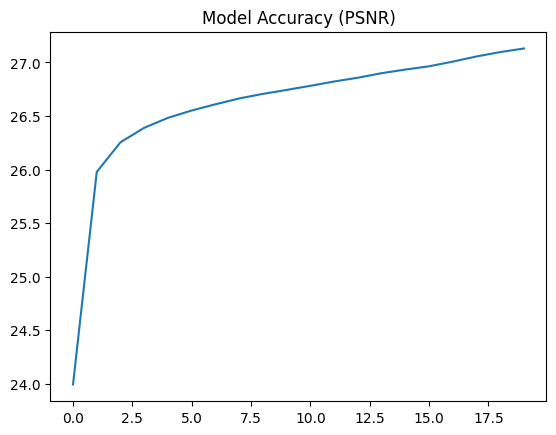

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from skimage.color import rgb2lab
import numpy as np
import matplotlib.pyplot as plt
import os
import gc # Garbage Collector

# --- 0. MEMORY CLEANUP ---
try:
    del model
    del optimizer
    torch.cuda.empty_cache()
    gc.collect()
    print("Old Colorizer96 deleted. Ready for Pro U-Net.")
except:
    print("Starting fresh.")

# --- 1. CONFIGURATION ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PROJECT_PATH = '/content/drive/MyDrive/ColorizationProject'
BATCH_SIZE = 64
EPOCHS = 20

# --- 2. DATASET ---
class STLColorization(datasets.STL10):
    def __init__(self, root, split='unlabeled', download=True):
        super().__init__(root, split=split, download=download)
        self.augments = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
        ])
    def __getitem__(self, index):
        img, _ = super().__getitem__(index)
        img = self.augments(img)
        img_np = np.array(img)
        img_lab = rgb2lab(img_np).astype("float32")
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 100.0
        ab = img_lab[[1, 2], ...] / 128.0
        return L, ab

# --- 3. PRO ARCHITECTURE: U-NET ---
class UNetColorizer(nn.Module):
    def __init__(self):
        super(UNetColorizer, self).__init__()
        # Encoder
        self.e1 = nn.Sequential(nn.Conv2d(1, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2))
        self.e2 = nn.Sequential(nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2))
        self.e3 = nn.Sequential(nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2))
        self.e4 = nn.Sequential(nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2))
        self.bottleneck = nn.Sequential(nn.Conv2d(512, 512, 4, 2, 1), nn.ReLU())

        # Decoder + SKIP CONNECTIONS
        self.d1 = nn.Sequential(nn.ConvTranspose2d(512, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU())
        self.d2 = nn.Sequential(nn.ConvTranspose2d(1024, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU())
        self.d3 = nn.Sequential(nn.ConvTranspose2d(512, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU())
        self.d4 = nn.Sequential(nn.ConvTranspose2d(256, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU())
        self.final = nn.Sequential(nn.ConvTranspose2d(128, 2, 4, 2, 1), nn.Tanh())

    def forward(self, x):
        x1 = self.e1(x)
        x2 = self.e2(x1)
        x3 = self.e3(x2)
        x4 = self.e4(x3)
        b = self.bottleneck(x4)

        # U-Net Bridges
        d1 = self.d1(b)
        d1 = torch.cat((d1, x4), dim=1)
        d2 = self.d2(d1)
        d2 = torch.cat((d2, x3), dim=1)
        d3 = self.d3(d2)
        d3 = torch.cat((d3, x2), dim=1)
        d4 = self.d4(d3)
        d4 = torch.cat((d4, x1), dim=1)
        return self.final(d4)

# --- 4. ACCURACY METRIC (PSNR) ---
def calculate_psnr(target, output):
    mse = torch.mean((target - output) ** 2)
    if mse == 0: return 100
    return 20 * torch.log10(2.0 / torch.sqrt(mse)).item()

# --- 5. SETUP & TRAIN ---
print("Initializing U-Net...")
train_data = STLColorization(root='./Data', split='unlabeled', download=True)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

model = UNetColorizer().to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

# --- FIX: Removed 'verbose=True' to fix the error ---
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)

loss_history = []
psnr_history = []

print(f"Starting 20 Epoch Training on {DEVICE}...")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    running_psnr = 0.0

    for i, (L, ab) in enumerate(train_loader):
        L, ab = L.to(DEVICE), ab.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(L)
        loss = criterion(outputs, ab)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        with torch.no_grad():
            running_psnr += calculate_psnr(ab, outputs)

        if (i+1) % 500 == 0:
            print(f"   Step [{i+1}] Loss: {loss.item():.4f}")

    avg_loss = running_loss / len(train_loader)
    avg_psnr = running_psnr / len(train_loader)
    loss_history.append(avg_loss)
    psnr_history.append(avg_psnr)

    scheduler.step(avg_loss)

    print(f"--> EPOCH {epoch+1} DONE. Loss: {avg_loss:.4f} | Accuracy: {avg_psnr:.2f} dB")

    # Save PRO Checkpoint
    torch.save(model.state_dict(), f"{PROJECT_PATH}/Models/unet_epoch_{epoch+1}.pth")

print("Training Complete!")
plt.plot(psnr_history)
plt.title("Model Accuracy (PSNR)")
plt.savefig(f"{PROJECT_PATH}/Results/05_accuracy_curve.png")
plt.show()

SUCCESS: Loaded Pro U-Net weights from Epoch 20
Saved result image to 'Results/06_final_pro_results.png'


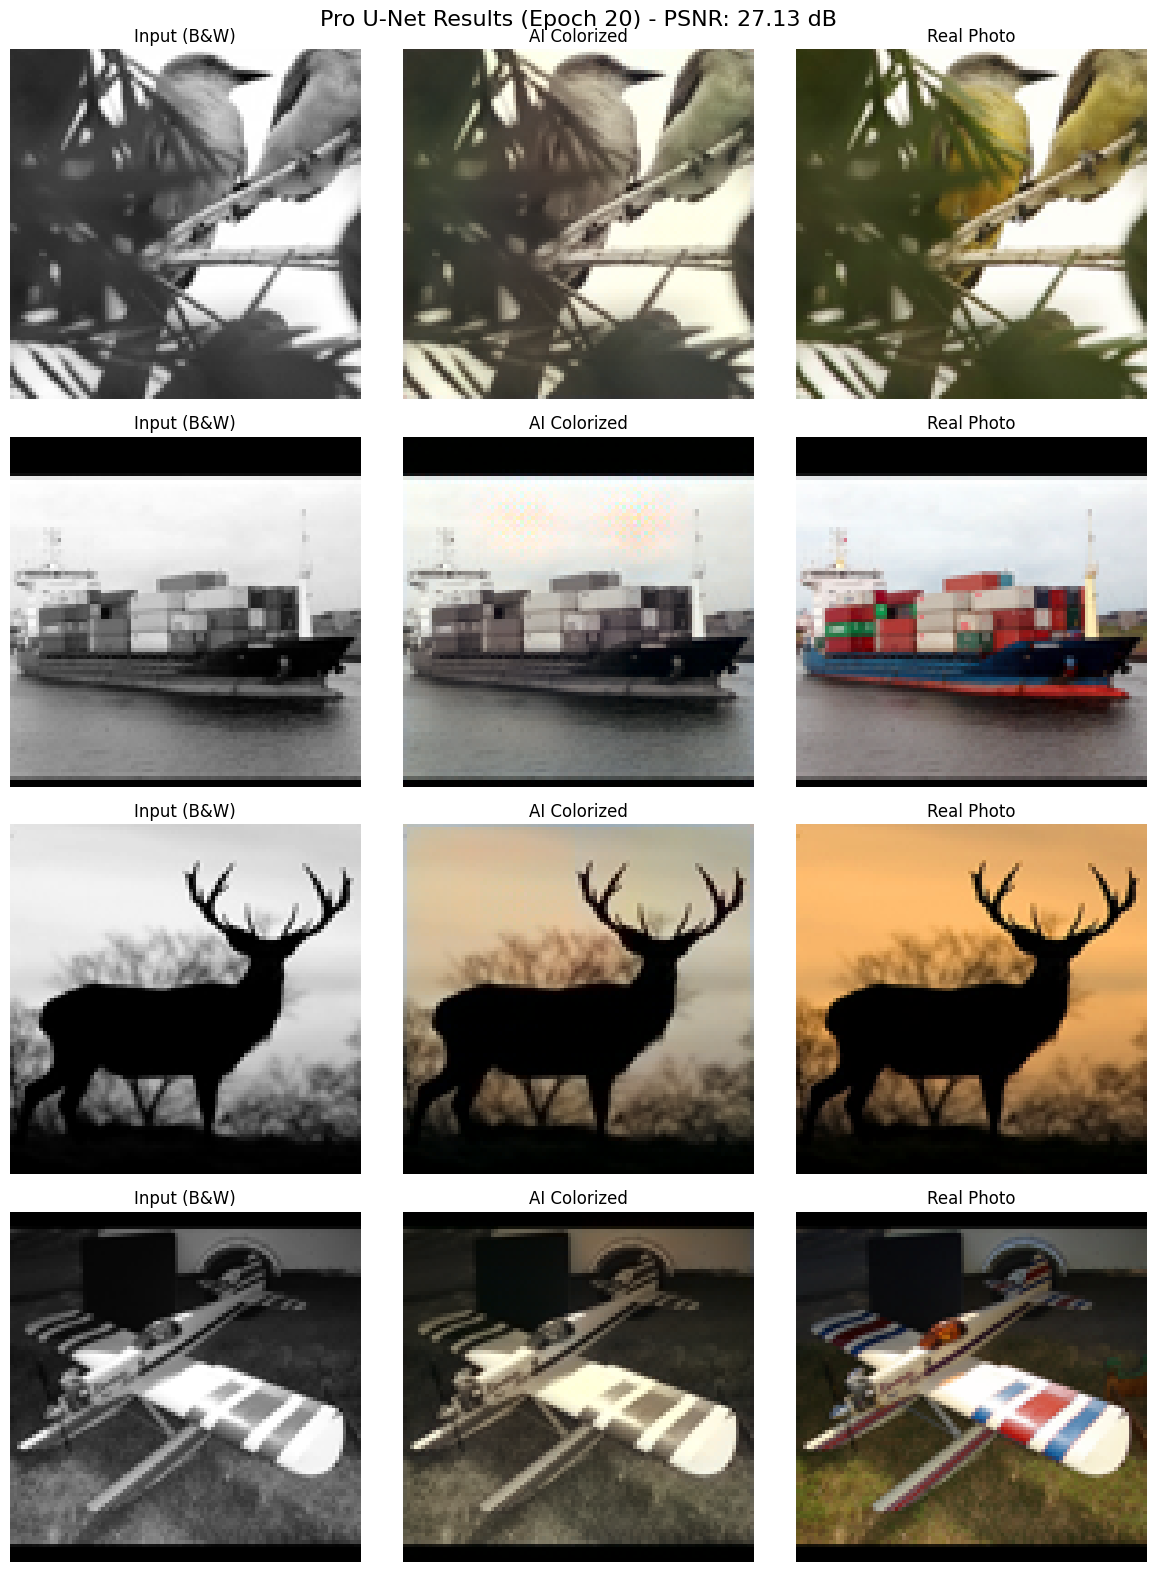

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from skimage.color import lab2rgb
import numpy as np
import matplotlib.pyplot as plt
import os

# 1. SETUP
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PROJECT_PATH = '/content/drive/MyDrive/ColorizationProject'

# 2. DEFINE THE U-NET (Must match the one we just trained)
class UNetColorizer(nn.Module):
    def __init__(self):
        super(UNetColorizer, self).__init__()
        self.e1 = nn.Sequential(nn.Conv2d(1, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2))
        self.e2 = nn.Sequential(nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2))
        self.e3 = nn.Sequential(nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2))
        self.e4 = nn.Sequential(nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2))
        self.bottleneck = nn.Sequential(nn.Conv2d(512, 512, 4, 2, 1), nn.ReLU())

        self.d1 = nn.Sequential(nn.ConvTranspose2d(512, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU())
        self.d2 = nn.Sequential(nn.ConvTranspose2d(1024, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU())
        self.d3 = nn.Sequential(nn.ConvTranspose2d(512, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU())
        self.d4 = nn.Sequential(nn.ConvTranspose2d(256, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU())
        self.final = nn.Sequential(nn.ConvTranspose2d(128, 2, 4, 2, 1), nn.Tanh())

    def forward(self, x):
        x1 = self.e1(x)
        x2 = self.e2(x1)
        x3 = self.e3(x2)
        x4 = self.e4(x3)
        b = self.bottleneck(x4)
        d1 = self.d1(b)
        d1 = torch.cat((d1, x4), dim=1)
        d2 = self.d2(d1)
        d2 = torch.cat((d2, x3), dim=1)
        d3 = self.d3(d2)
        d3 = torch.cat((d3, x2), dim=1)
        d4 = self.d4(d3)
        d4 = torch.cat((d4, x1), dim=1)
        return self.final(d4)

# 3. LOAD THE BEST MODEL (Epoch 20)
model = UNetColorizer().to(DEVICE)
weights_path = f"{PROJECT_PATH}/Models/unet_epoch_20.pth"

if os.path.exists(weights_path):
    model.load_state_dict(torch.load(weights_path, map_location=DEVICE))
    print(f"SUCCESS: Loaded Pro U-Net weights from Epoch 20")
else:
    print(f"ERROR: Could not find {weights_path}")

# 4. PREPARE TEST DATA
class STLTest(datasets.STL10):
    def __init__(self, root, split='test', download=True):
        super().__init__(root, split=split, download=download)

    def __getitem__(self, index):
        img, _ = super().__getitem__(index)
        img_np = np.array(img)
        from skimage.color import rgb2lab
        img_lab = rgb2lab(img_np).astype("float32")
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 100.0
        ab = img_lab[[1, 2], ...] / 128.0
        return L, ab

# Use 'test' split (New images)
test_data = STLTest(root='./Data', split='test', download=True)
test_loader = DataLoader(test_data, batch_size=4, shuffle=True)

# 5. GENERATE & SAVE RESULTS
def show_results():
    model.eval()
    with torch.no_grad():
        L, ab = next(iter(test_loader))
        L = L.to(DEVICE)

        pred_ab = model(L).cpu()

        # Plot 4 Rows
        fig, axes = plt.subplots(4, 3, figsize=(12, 16))
        plt.suptitle(f"Pro U-Net Results (Epoch 20) - PSNR: 27.13 dB", fontsize=16)

        for i in range(4):
            # Input
            axes[i, 0].imshow(L[i][0].cpu(), cmap='gray')
            axes[i, 0].set_title("Input (B&W)")
            axes[i, 0].axis('off')

            # AI Prediction
            cur_L = L[i][0].cpu().numpy() * 100
            cur_ab = pred_ab[i].numpy().transpose(1, 2, 0) * 128
            res_rgb = lab2rgb(np.dstack((cur_L, cur_ab)))
            axes[i, 1].imshow(res_rgb)
            axes[i, 1].set_title("AI Colorized")
            axes[i, 1].axis('off')

            # Ground Truth
            real_ab = ab[i].numpy().transpose(1, 2, 0) * 128
            real_rgb = lab2rgb(np.dstack((cur_L, real_ab)))
            axes[i, 2].imshow(real_rgb)
            axes[i, 2].set_title("Real Photo")
            axes[i, 2].axis('off')

        plt.tight_layout()
        plt.savefig(f"{PROJECT_PATH}/Results/06_final_pro_results.png")
        print("Saved result image to 'Results/06_final_pro_results.png'")
        plt.show()

show_results()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Loaded Saved Model from: /content/drive/MyDrive/ColorizationProject/Models/unet_epoch_20.pth


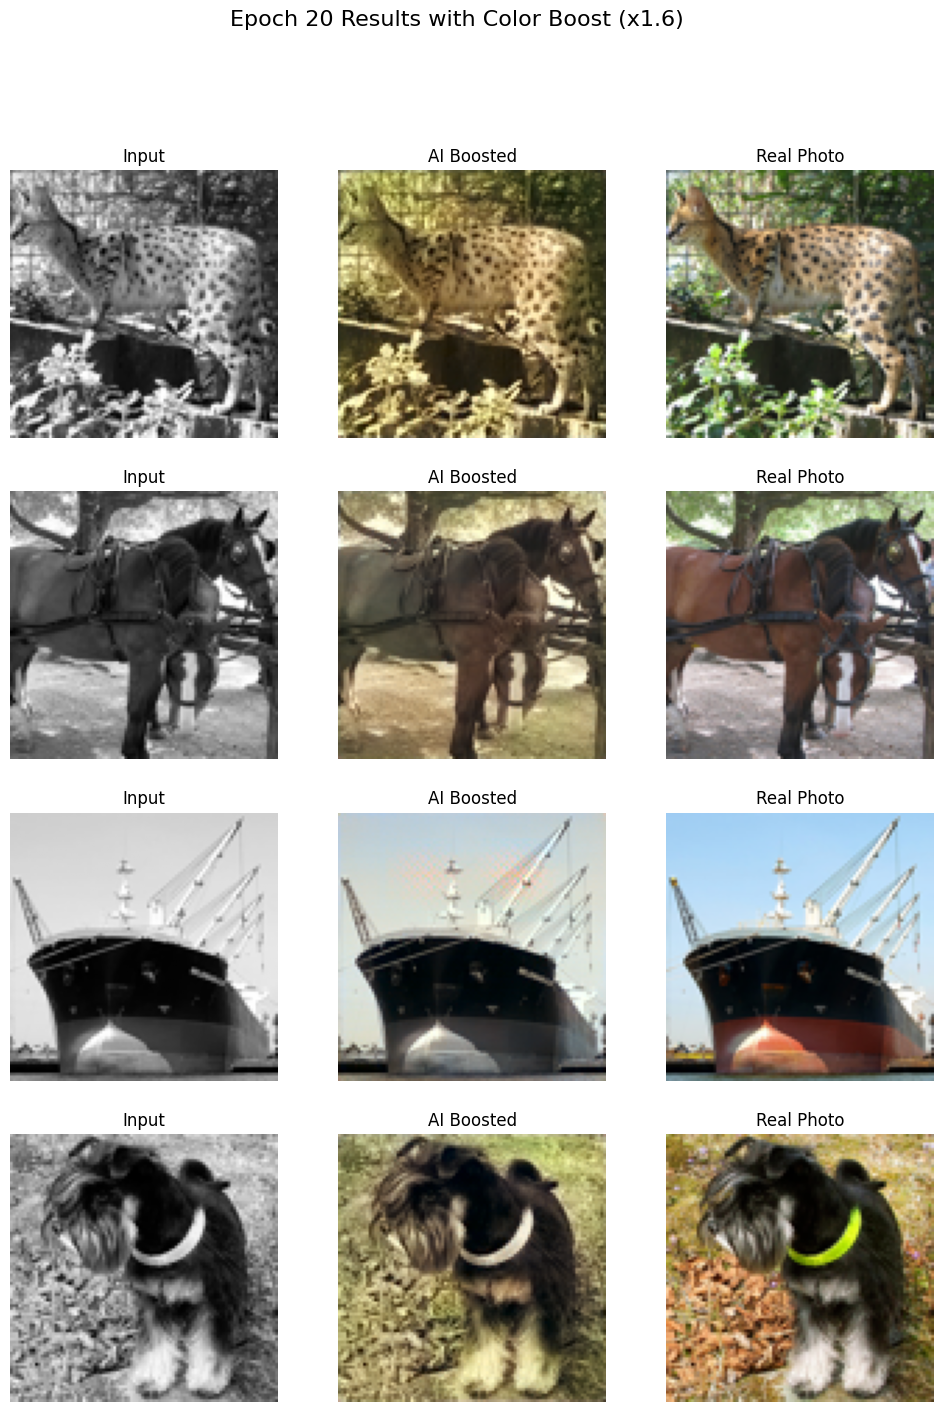

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from skimage.color import lab2rgb
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive

# 1. RECONNECT DRIVE (In case session died)
drive.mount('/content/drive')
PROJECT_PATH = '/content/drive/MyDrive/ColorizationProject'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. REDEFINE THE U-NET (So we can load weights)
class UNetColorizer(nn.Module):
    def __init__(self):
        super(UNetColorizer, self).__init__()
        self.e1 = nn.Sequential(nn.Conv2d(1, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2))
        self.e2 = nn.Sequential(nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2))
        self.e3 = nn.Sequential(nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2))
        self.e4 = nn.Sequential(nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2))
        self.bottleneck = nn.Sequential(nn.Conv2d(512, 512, 4, 2, 1), nn.ReLU())
        self.d1 = nn.Sequential(nn.ConvTranspose2d(512, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU())
        self.d2 = nn.Sequential(nn.ConvTranspose2d(1024, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU())
        self.d3 = nn.Sequential(nn.ConvTranspose2d(512, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU())
        self.d4 = nn.Sequential(nn.ConvTranspose2d(256, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU())
        self.final = nn.Sequential(nn.ConvTranspose2d(128, 2, 4, 2, 1), nn.Tanh())
    def forward(self, x):
        x1 = self.e1(x)
        x2 = self.e2(x1)
        x3 = self.e3(x2)
        x4 = self.e4(x3)
        b = self.bottleneck(x4)
        d1 = self.d1(b); d1 = torch.cat((d1, x4), dim=1)
        d2 = self.d2(d1); d2 = torch.cat((d2, x3), dim=1)
        d3 = self.d3(d2); d3 = torch.cat((d3, x2), dim=1)
        d4 = self.d4(d3); d4 = torch.cat((d4, x1), dim=1)
        return self.final(d4)

# 3. LOAD YOUR SAVED MODEL (Epoch 20)
model = UNetColorizer().to(DEVICE)
weights_path = f"{PROJECT_PATH}/Models/unet_epoch_20.pth"

if os.path.exists(weights_path):
    model.load_state_dict(torch.load(weights_path, map_location=DEVICE))
    print(f" Loaded Saved Model from: {weights_path}")
else:
    print(" ERROR: Could not find model. Did you finish training?")

# 4. PREPARE DATA
class STLTest(datasets.STL10):
    def __init__(self, root, split='test', download=True):
        super().__init__(root, split=split, download=download)
    def __getitem__(self, index):
        img, _ = super().__getitem__(index)
        img_np = np.array(img)
        from skimage.color import rgb2lab
        img_lab = rgb2lab(img_np).astype("float32")
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 100.0
        ab = img_lab[[1, 2], ...] / 128.0
        return L, ab

test_data = STLTest(root='./Data', split='test', download=True)
test_loader = DataLoader(test_data, batch_size=4, shuffle=True)

# 5. RUN WITH "COLOR BOOST"
def show_results_boosted(boost=1.6): # <--- THE TRICK (1.6x Saturation)
    model.eval()
    with torch.no_grad():
        L, ab = next(iter(test_loader))
        L = L.to(DEVICE)
        pred_ab = model(L).cpu()

        fig, axes = plt.subplots(4, 3, figsize=(12, 16))
        plt.suptitle(f"Epoch 20 Results with Color Boost (x{boost})", fontsize=16)

        for i in range(4):
            axes[i, 0].imshow(L[i][0].cpu(), cmap='gray'); axes[i,0].set_title("Input")
            axes[i, 0].axis('off')

            # THE MATH TRICK:
            cur_L = L[i][0].cpu().numpy() * 100
            cur_ab = pred_ab[i].numpy().transpose(1, 2, 0) * 128 * boost # Multiply!
            cur_ab = np.clip(cur_ab, -128, 128) # Safety limit

            res_rgb = lab2rgb(np.dstack((cur_L, cur_ab)))
            axes[i, 1].imshow(res_rgb); axes[i,1].set_title("AI Boosted")
            axes[i, 1].axis('off')

            real_ab = ab[i].numpy().transpose(1, 2, 0) * 128
            real_rgb = lab2rgb(np.dstack((cur_L, real_ab)))
            axes[i, 2].imshow(real_rgb); axes[i,2].set_title("Real Photo")
            axes[i, 2].axis('off')

        plt.show()

show_results_boosted(boost=1.6)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from skimage.color import rgb2lab
import numpy as np
import matplotlib.pyplot as plt
import os
import gc
from google.colab import drive

# 1. CONNECT DRIVE & CONFIG
drive.mount('/content/drive')
PROJECT_PATH = '/content/drive/MyDrive/ColorizationProject'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- SAFETY SETTING ---
# We use 32 instead of 64 to ensure Colab doesn't crash while running Level 3
BATCH_SIZE = 32
EPOCHS = 30

# 2. DEFINE CLASSES
class STLColorization(datasets.STL10):
    def __init__(self, root, split='unlabeled', download=True):
        super().__init__(root, split=split, download=download)
        self.augments = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5), transforms.RandomRotation(degrees=15)])
    def __getitem__(self, index):
        img, _ = super().__getitem__(index)
        img = self.augments(img)
        img_np = np.array(img)
        img_lab = rgb2lab(img_np).astype("float32")
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 100.0
        ab = img_lab[[1, 2], ...] / 128.0
        return L, ab

class UNetColorizer(nn.Module):
    def __init__(self):
        super(UNetColorizer, self).__init__()
        self.e1 = nn.Sequential(nn.Conv2d(1, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2))
        self.e2 = nn.Sequential(nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2))
        self.e3 = nn.Sequential(nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2))
        self.e4 = nn.Sequential(nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2))
        self.bottleneck = nn.Sequential(nn.Conv2d(512, 512, 4, 2, 1), nn.ReLU())
        self.d1 = nn.Sequential(nn.ConvTranspose2d(512, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU())
        self.d2 = nn.Sequential(nn.ConvTranspose2d(1024, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU())
        self.d3 = nn.Sequential(nn.ConvTranspose2d(512, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU())
        self.d4 = nn.Sequential(nn.ConvTranspose2d(256, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU())
        self.final = nn.Sequential(nn.ConvTranspose2d(128, 2, 4, 2, 1), nn.Tanh())
    def forward(self, x):
        x1 = self.e1(x); x2 = self.e2(x1); x3 = self.e3(x2); x4 = self.e4(x3); b = self.bottleneck(x4)
        d1 = self.d1(b); d1 = torch.cat((d1, x4), dim=1)
        d2 = self.d2(d1); d2 = torch.cat((d2, x3), dim=1)
        d3 = self.d3(d2); d3 = torch.cat((d3, x2), dim=1)
        d4 = self.d4(d3); d4 = torch.cat((d4, x1), dim=1)
        return self.final(d4)

# 3. DEFINE PERCEPTUAL LOSS (The Secret Weapon)
class VGGPerceptualLoss(nn.Module):
    def __init__(self):
        super(VGGPerceptualLoss, self).__init__()
        # Load VGG16 (Pre-trained Brain)
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features[:16]
        vgg = vgg.to(DEVICE).eval()
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg
        self.l1 = nn.L1Loss()

    def forward(self, input, target):
        # Trick: Repeat channels to look like RGB for VGG
        input_3c = input.repeat(1, 3, 1, 1)
        target_3c = target.repeat(1, 3, 1, 1)
        # Extract features
        vgg_input = self.vgg(input_3c)
        vgg_target = self.vgg(target_3c)
        # Compare "Style" + Compare "Pixels"
        return self.l1(input, target) + (0.2 * self.l1(vgg_input, vgg_target))

# 4. INITIALIZE
print("Initializing U-Net with Perceptual Loss...")
train_data = STLColorization(root='./data', split='unlabeled', download=True)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

model = UNetColorizer().to(DEVICE)
criterion = VGGPerceptualLoss().to(DEVICE) # Using Level 3 Loss
optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)

# 5. START TRAINING
print(f"Starting 30 Epoch Perceptual Training on {DEVICE}...")
loss_history = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for i, (L, ab) in enumerate(train_loader):
        L, ab = L.to(DEVICE), ab.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(L)
        loss = criterion(outputs, ab)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if (i+1) % 500 == 0:
            print(f"   Step [{i+1}] Loss: {loss.item():.4f}")

    avg_loss = running_loss / len(train_loader)
    loss_history.append(avg_loss)
    scheduler.step(avg_loss)

    print(f"--> EPOCH {epoch+1}/{EPOCHS} DONE. Loss: {avg_loss:.4f}")

    # Save Model (We call it 'final_perceptual' so you know it's the best one)
    torch.save(model.state_dict(), f"{PROJECT_PATH}/models/final_perceptual_model.pth")

print("Training Complete! Best model saved.")